# Convolutional AutoEncoders

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

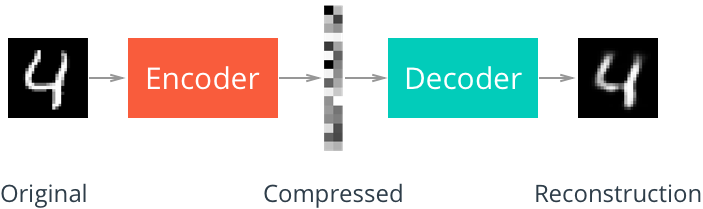

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

/home/sadat/miniconda3/envs/mmsign/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device Agnostic Code

In [2]:
try:
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
except:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [3]:
# Transforms images to a PyTorch tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root='./data',
                        train=True,
                        download=True,
                        transform=tensor_transform)

# DataLoader is used to load the dataset for training
loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=20,
                                    shuffle=True)

## Visualise the data

(20, 1, 28, 28)


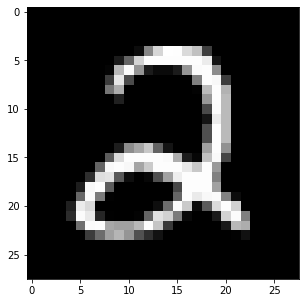

In [4]:
# Get a batch
dataiter = iter(loader)
images, labels = next(dataiter)
images = images.numpy()
print(images.shape)

# Plot an image
img = np.squeeze(images[0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Autoencoder

In [5]:
images.shape

(20, 1, 28, 28)

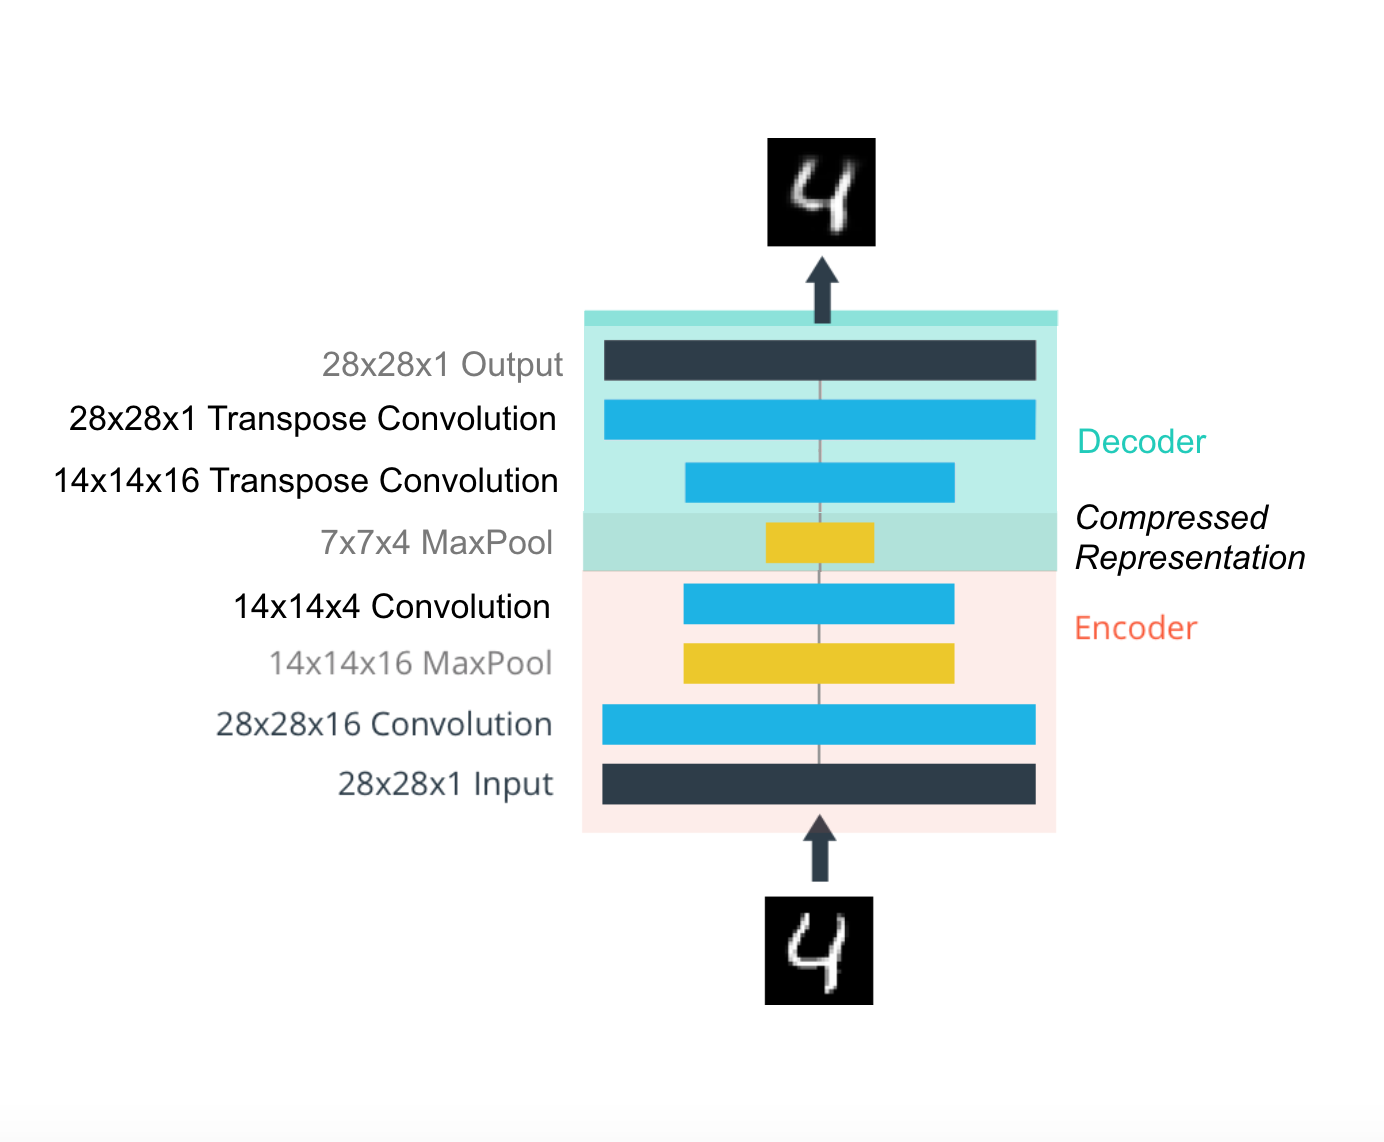

In [6]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder 1 ==> 16 ==> 4
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 4, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        # Decoder 4 ==> 16 == > 1
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        code = self.encode(x)
        decode = self.decode(code)
        return decode
    
model = AE()

## Loss function and optimiser

In [7]:
# Specify loss function
loss_fn = nn.MSELoss()

# Specify loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the model

In [8]:
epochs = 30
outputs = []
losses = []

# Transfer model to device
model.to(device)

for epoch in range(epochs):
    # Reset train loss
    train_loss = 0.0
    for (image, _) in loader:
        # Move data to device
        image = image.to(device)
        
        # Forward pass
        output = model(image)
        loss = loss_fn(output, image)
        
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Calculate batch loss
        train_loss += loss.item()*image.size(0)
    
    train_loss = train_loss/len(loader)
    losses.append(train_loss)
    outputs.append((epochs, image, output))
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

Epoch: 0 	Training Loss: 0.471615
Epoch: 1 	Training Loss: 0.216233
Epoch: 2 	Training Loss: 0.200569
Epoch: 3 	Training Loss: 0.192451
Epoch: 4 	Training Loss: 0.187094
Epoch: 5 	Training Loss: 0.183532
Epoch: 6 	Training Loss: 0.181174
Epoch: 7 	Training Loss: 0.179234
Epoch: 8 	Training Loss: 0.177744
Epoch: 9 	Training Loss: 0.176481
Epoch: 10 	Training Loss: 0.175564
Epoch: 11 	Training Loss: 0.174990
Epoch: 12 	Training Loss: 0.174482
Epoch: 13 	Training Loss: 0.173818
Epoch: 14 	Training Loss: 0.173329
Epoch: 15 	Training Loss: 0.172166
Epoch: 16 	Training Loss: 0.171293
Epoch: 17 	Training Loss: 0.170668
Epoch: 18 	Training Loss: 0.170205
Epoch: 19 	Training Loss: 0.169893
Epoch: 20 	Training Loss: 0.169472
Epoch: 21 	Training Loss: 0.169210
Epoch: 22 	Training Loss: 0.168778
Epoch: 23 	Training Loss: 0.168430
Epoch: 24 	Training Loss: 0.167989
Epoch: 25 	Training Loss: 0.167687
Epoch: 26 	Training Loss: 0.167350
Epoch: 27 	Training Loss: 0.167019
Epoch: 28 	Training Loss: 0.16

Text(0.5, 0, 'Epoch')

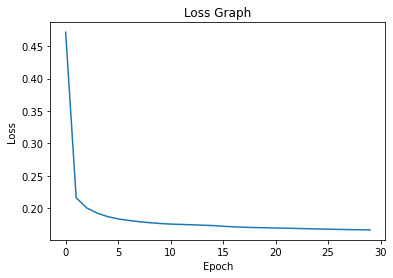

In [9]:
plt.plot(losses)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')

## Model Testing

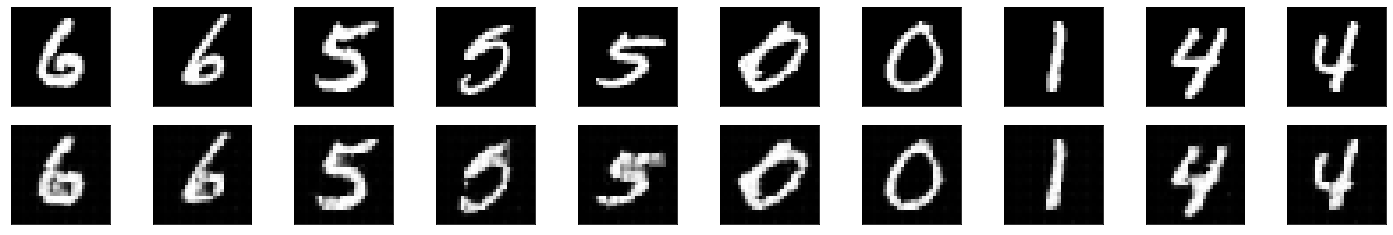

In [10]:
# Get first batch
dataiter = iter(loader)
imgs, labels = next(dataiter)

# Get sample outputs
output = model(imgs.to(device))
# Prep images for display
images = imgs.numpy()

# Output is resized into a batch of images
output = output.view(20, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Latent Space Representation

In [ ]:
# Forward pass only on the encoder
code = model.encode(imgs.to(device))
code = code.cpu().detach().numpy()

# Plot the 4 channels to see the latent space representation
f, axarr = plt.subplots(4,10,sharex=True, sharey=True)
for i in range(10):
    for j in range(4):
        axarr[j,i].imshow(code[i][j])

Here, it seems that only two channels are being used to actually represent the numbers. For an experiment, we could try retraining the model with the latent space of shape, (2, 7, 7) instead (4, 7, 7) and see if that still works.

# Reduced Latent Space

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder 1 ==> 16 ==> 2
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 2, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        # Decoder 2 ==> 16 == > 1
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(2, 16, 2, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, 2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        code = self.encode(x)
        decode = self.decode(code)
        return decode
    
model = AE()

# Specify loss function
loss_fn = nn.MSELoss()

# Specify loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 30
outputs = []
losses = []

# Transfer model to device
model.to(device)

for epoch in range(epochs):
    # Reset train loss
    train_loss = 0.0
    for (image, _) in loader:
        # Move data to device
        image = image.to(device)
        
        # Forward pass
        output = model(image)
        loss = loss_fn(output, image)
        
        optimizer.zero_grad()
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Calculate batch loss
        train_loss += loss.item()*image.size(0)
    
    train_loss = train_loss/len(loader)
    losses.append(train_loss)
    outputs.append((epochs, image, output))
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')

In [ ]:
plt.plot(losses)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [ ]:
# Get first batch
dataiter = iter(loader)
imgs, labels = next(dataiter)

# Get sample outputs
output = model(imgs.to(device))
# Prep images for display
images = imgs.numpy()

# Output is resized into a batch of images
output = output.view(20, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
# Forward pass only on the encoder
code = model.encode(imgs.to(device))
code = code.cpu().detach().numpy()

# Plot the 2 channels to see the latent space representation
f, axarr = plt.subplots(2,10,sharex=True, sharey=True)
for i in range(10):
    for j in range(2):
        axarr[j,i].imshow(code[i][j])

It looks neat! Our loss is less than our previous model too. 